### Step 1: Construct the assays & compounds table

#### 1.1 Construct the assays table,with fields as the following

CID VARCHAR(30) PRIMARY KEY,  
r_inhibition_at_20_uM DOUBLE,  
r_inhibition_at_50_uM DOUBLE,  
r_avg_IC50 DOUBLE,  
f_inhibition_at_20_uM DOUBLE,  
f_inhibition_at_50_uM DOUBLE,  
f_avg_IC50 DOUBLE,  
f_avg_pIC50 DOUBLE  


In [109]:
import sqlite3 as sql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import csv
from pathlib import Path

In [2]:
# Add file name here
data_file = Path('activity_data.csv')
db_file = Path('MPro_binding.db')

In [3]:
# 1: drop the database
for table_name in ('compounds','assays'):
    sql.connect(db_file).execute('DROP TABLE IF EXISTS ' + table_name)

In [4]:
# 2: create a new database
conn = sql.connect(db_file)
conn.execute('''
CREATE TABLE assays
(
    CID VARCHAR(20) PRIMARY KEY,
    r_inhibition_at_20_uM DECIMAL,
    r_inhibition_at_50_uM DECIMAL,
    r_avg_IC50 DECIMAL,
    f_inhibition_at_20_uM DECIMAL,
    f_inhibition_at_50_uM DECIMAL,
    f_avg_IC50 DECIMAL,
    f_avg_pIC50 DECIMAL
)

''')

conn.execute('''
CREATE TABLE compounds
(
    CID VARCHAR(20) PRIMARY KEY,
    SMILES VARCHAR(2000) NOT NULL,
    FOREIGN KEY(CID) REFERENCES assays(CID) 
)
''')


In [5]:
# 3: Add records to the table assays 
itemlist = []
with open(data_file,encoding="utf8") as csvfile:
    reader = csv.DictReader(csvfile,delimiter=',')
    for row in reader:
        itemlist.append((row['CID'],row['r_inhibition_at_20_uM'],
                         row['r_inhibition_at_50_uM'],row['r_avg_IC50'],
                         row['f_inhibition_at_20_uM'],row['f_inhibition_at_50_uM'],
                         row['f_avg_IC50'],row['f_avg_pIC50']))
print(itemlist)
conn = self.get_conn()
conn.executemany('INSERT INTO <TABLE> (Col1, Col2) VALUES(?,?)', ((1,2), (2,3)))
print('###############################')
        
# 4: Add records to the table compounds
itemlist = []
with open(data_file, newline='',encoding="utf8") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        print(type(row['CID']))
        print(type(row['SMILES']))
        itemlist.append((row['CID'],row['SMILES']))

#print(itemlist)
conn = sql.connect(db_file)
conn.executemany("INSERT INTO compounds (CID,SMILES) VALUES(?,?)",itemlist)
                
                

[('LUO-POS-e1dab717-11', '', '', '', '', '', '0.275118241099123', ''), ('LUO-POS-e1dab717-12', '', '', '', '', '', '0.202766791018038', ''), ('MAT-POS-e48723dc-1', '', '', '', '', '', '55.4539472183434', ''), ('MAT-POS-e48723dc-2', '', '', '', '', '', '0.0500000007450581', ''), ('LUO-POS-9931618f-2', '', '', '', '', '', '0.0527566448489595', ''), ('EDJ-MED-b6c6ee2b-2', '', '', '', '', '', '0.153279934357818', ''), ('EDJ-MED-b6c6ee2b-3', '', '', '', '', '', '0.214885085602627', ''), ('EDJ-MED-5cd3920d-5', '', '', '', '', '', '0.15535120394062', ''), ('EDJ-MED-5cd3920d-6', '', '', '', '', '', '0.15665931676081', ''), ('MAT-POS-50a80394-1', '', '', '', '', '', '0.106542506041203', ''), ('MAT-POS-50a80394-2', '', '', '', '', '', '0.0744085085108016', ''), ('MAT-POS-be048f2c-5', '', '', '', '', '', '0.297012069374338', ''), ('MAT-POS-be048f2c-6', '', '', '', '', '', '0.267639768802499', ''), ('MAT-POS-be048f2c-7', '', '', '', '', '', '0.162875697461307', ''), ('EDJ-MED-cc48ee33-4', '', '', 

OperationalError: no such table: nonsense

In [10]:
# 5. check whether records have been inserted successfully (show the table)
'''
for table in ('assays','compounds'):
    cur = sql.connect(db_file).execute('SELECT sql FROM sqlite_master WHERE name=\'' + table + '\'')
    row = cur.fetchall()
    if row is not None:
        print(table+'\n')
        print(row[0:5])
    else:
        print('Table ' + table + ' not found')
'''
conn = sql.connect(db_file)
result = conn.execute('''
    SELECT
        SMILES
    FROM 
        compounds''')
print(result)
for row in result:
    print(row)


### We give up sql, and we used pandas instead

In [7]:
df_temp = pd.read_csv(data_file)
assays = df_temp[['CID','r_inhibition_at_20_uM','r_inhibition_at_50_uM','r_avg_IC50','f_inhibition_at_20_uM','f_inhibition_at_50_uM','f_avg_IC50','f_avg_pIC50']]
compounds = df_temp[['CID','SMILES']]

In [9]:
assays.head()

,CID,r_inhibition_at_20_uM,r_inhibition_at_50_uM,r_avg_IC50,f_inhibition_at_20_uM,f_inhibition_at_50_uM,f_avg_IC50,f_avg_pIC50
0,LUO-POS-e1dab717-11,NaN,NaN,NaN,NaN,NaN,0.275118,NaN
1,LUO-POS-e1dab717-12,NaN,NaN,NaN,NaN,NaN,0.202767,NaN
2,MAT-POS-e48723dc-1,NaN,NaN,NaN,NaN,NaN,55.453947,NaN
3,MAT-POS-e48723dc-2,NaN,NaN,NaN,NaN,NaN,0.050000,NaN
4,LUO-POS-9931618f-2,NaN,NaN,NaN,NaN,NaN,0.052757,NaN


In [10]:

compounds.head()

,CID,SMILES
0,LUO-POS-e1dab717-11,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...
1,LUO-POS-e1dab717-12,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...
2,MAT-POS-e48723dc-1,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...
3,MAT-POS-e48723dc-2,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...
4,LUO-POS-9931618f-2,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...


### Step 2: data exploration 

#### 2.1: Molecular descriptors

In [12]:
#%pip install rdkit

Note: you may need to restart the kernel to use updated packages.


In [21]:
import rdkit.Chem as Chem
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumHDonors, NumHAcceptors

In [22]:
def calculate_descriptors(smile):
    molecule = Chem.MolFromSmiles(smile)
    if molecule:
        hbd, hba, mw, pow = [x(molecule) for x in [NumHDonors, NumHAcceptors, MolWt, MolLogP]]
        res = [hbd, hba, mw, pow]
    else:
        res = [None] * 4
    return res

In [28]:
print(compounds['SMILES'][4])
print(calculate_descriptors(compounds['SMILES'][4]))

CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc2C1=O
[1, 4, 448.9100000000002, 2.7647000000000013]


In [25]:
hbd, hba, mw, pow =[],[],[],[]
for i in range(len(compounds)):
    hbd_temp, hba_temp, mw_temp, pow_temp = calculate_descriptors(compounds['SMILES'][i])
    hbd.append(hbd_temp)
    hba.append(hba_temp)
    mw.append(mw_temp)
    pow.append(pow_temp)
compounds['hbd'] = hbd
compounds['hba'] = hba
compounds['mw'] = mw
compounds['pow'] = pow

C:\Users\Swimming\AppData\Local\Temp\ipykernel_43692\2427077118.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compounds['hbd'] = hbd
C:\Users\Swimming\AppData\Local\Temp\ipykernel_43692\2427077118.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compounds['hba'] = hba
C:\Users\Swimming\AppData\Local\Temp\ipykernel_43692\2427077118.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [26]:
compounds.head()

,CID,SMILES,hbd,hba,mw,pow
0,LUO-POS-e1dab717-11,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,1,5,498.992,2.7033
1,LUO-POS-e1dab717-12,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,1,5,525.030,3.0934
2,MAT-POS-e48723dc-1,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,1,4,474.948,3.2973
3,MAT-POS-e48723dc-2,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,1,4,474.948,3.2973
4,LUO-POS-9931618f-2,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,1,4,448.910,2.7647


* 5 or fewer hydrogen bond donors;
* 10 or fewer hydrogen bond acceptors;
* A molecular weight (MW) of less than 500 Daltons;
* An octanol-water partition coefficient (log Po/w) of less than 5. Larger log Po/w means more lipophilic (i.e., less water soluble).

In [32]:
# Select compounds based on Lipinski's rule of five
print('Total number of compounds: ',len(compounds))
compounds_lip_strict = compounds.loc[(compounds['hbd']<=5) & (compounds['hba']<=10) & (compounds['mw']<500) & (compounds['pow']<5)]
print('Number of compounds after selected by Lipinski rule: ',len(compounds_lip_strict))

Total number of compounds:  2062
Number of compounds after selected by Lipinski rule:  1539


In [33]:
assays_lip_strict = assays.loc[(compounds['hbd']<=5) & (compounds['hba']<=10) & (compounds['mw']<500) & (compounds['pow']<5)]

In [36]:
print('Number of assays after Lipinski rule: ',len(assays_lip_strict))

Number of assays after Lipinski rule:  1539


In [48]:
%matplotlib inline
def plot_hist(data_1,data_2,nbins=100):
    data_1 = data_1.to_numpy()
    data_2 = data_2.to_numpy()
    plt.hist(data_1[~np.isnan(data_1)],bins=nbins,alpha=0.3,density=True)
    plt.hist(data_2[~np.isnan(data_2)],bins=nbins,alpha=0.3,density=True)

198.0


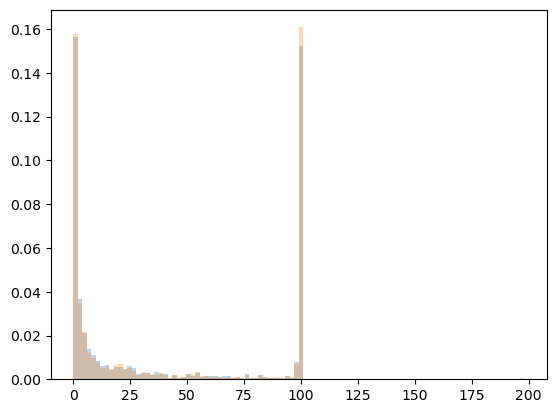

In [49]:
print(max(assays['f_avg_IC50']))
plot_hist(assays['f_avg_IC50'],assays_lip_strict['f_avg_IC50'])

In [61]:
(compounds['hbd']<=5).astype(int) + (compounds['hba']<=10).astype(int) + (compounds['mw']<500).astype(int) + (compounds['pow']<5).astype(int)>=3

0       4
1       3
2       4
3       4
4       4
       ..
2057    4
2058    4
2059    4
2060    4
2061    4
Length: 2062, dtype: int32

In [62]:
compounds_lip = compounds[(compounds['hbd']<=5).astype(int) + (compounds['hba']<=10).astype(int) + (compounds['mw']<500).astype(int) + (compounds['pow']<5).astype(int)>=3]
assays_lip = assays[(compounds['hbd']<=5).astype(int) + (compounds['hba']<=10).astype(int) + (compounds['mw']<500).astype(int) + (compounds['pow']<5).astype(int)>=3]

In [63]:
print('Number of compounds after less strict lipinski rule: ',len(compounds_lip))

Number of compounds after less strict lipinski rule:  1974


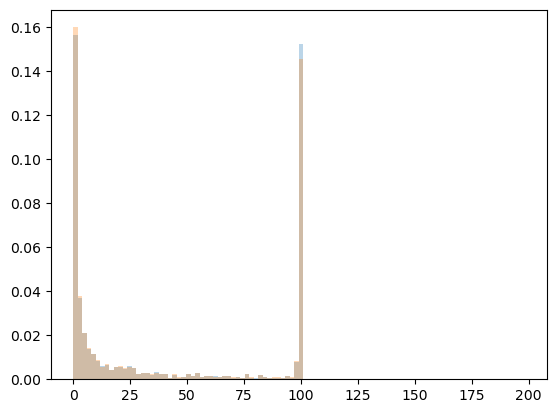

In [65]:
plot_hist(assays['f_avg_IC50'],assays_lip['f_avg_IC50'])

By filtering the compounds in a less strict way, we definitely obtained more compounds!


#### 2.2 ECFP fingerprints

In [66]:
# Check whether we have revised the compounds
len(compounds)

2062

In [79]:
from rdkit.Chem import AllChem
def ECFP(smile,radius=2,nBits=2048):
    molecule = Chem.MolFromSmiles(smile)
    return AllChem.GetMorganFingerprintAsBitVect(molecule,radius,nBits=nBits)

from rdkit.DataStructs import FingerprintSimilarity,DiceSimilarity


In [97]:
ECFP_temp = []
for i in range(len(compounds)):
    ECFP_temp.append(ECFP(compounds['SMILES'][i]))
compounds['ECFP'] = ECFP_temp

C:\Users\Swimming\AppData\Local\Temp\ipykernel_43692\313926559.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compounds['ECFP'] = ECFP_temp


In [102]:
compounds.head()

,CID,SMILES,hbd,hba,mw,pow,ECFP
0,LUO-POS-e1dab717-11,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,1,5,498.992,2.7033,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LUO-POS-e1dab717-12,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,1,5,525.030,3.0934,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,MAT-POS-e48723dc-1,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,1,4,474.948,3.2973,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,MAT-POS-e48723dc-2,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,1,4,474.948,3.2973,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,LUO-POS-9931618f-2,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,1,4,448.910,2.7647,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [105]:
def compute_similarity(fingerprint_1,fingerprint_2):
    return FingerprintSimilarity(fingerprint_1,fingerprint_2, metric=DiceSimilarity)


In [114]:
similarity_matrix = np.zeros((len(compounds),len(compounds)))
for i in range(200):
    for j in range(200):
        similarity_matrix[i,j] = compute_similarity(compounds['ECFP'][i],compounds['ECFP'][j])

In [115]:
print(similarity_matrix)

[[1.         0.91176471 0.73846154 ... 0.         0.         0.        ]
 [0.91176471 1.         0.70149254 ... 0.         0.         0.        ]
 [0.73846154 0.70149254 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


<AxesSubplot:>

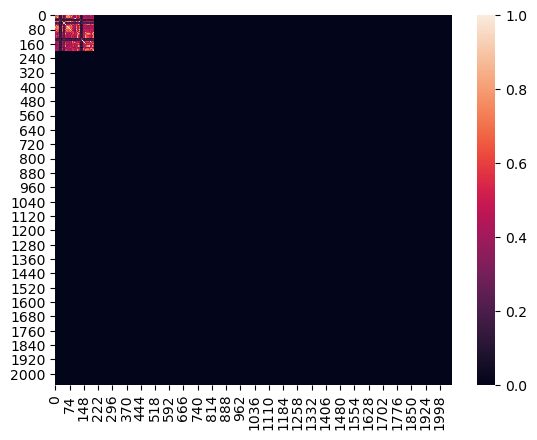

In [116]:
seaborn.heatmap(similarity_matrix)